# Check_spinup global results
- reads in MIMICS results and checks for change in soil and veg C pool & fluxes
- data are here /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS/OUTPUT_CN/SPIN

#### --- CRUNCEP runs  --- :
- `MIMICS_def`, as in GRL 2019 paper, but with additional CN parameters
- `MIMICS_desorb`, increased desorb 5x as in Zhang 2000 paper
- `MIMICS_desorb2` decreased desorb 10x from default, decreased fPHYS 5x from default
            FI: FI_phys = 0.005, 10x lower, FI_chem = 0.10, 2x higher;  
            KO = 9 (from 6) to increase SOMc stocks

#### --- GSWP3 runs  --- : 
- `MIMICS_desorb2_GSWP3` as above, but pointing to  GSPW3
- `MIMICS_mod3_GSWP3`, increase KO = 12, and double MIC turnover to increase SOC stocks and reduce MIC
- `MIMICS_mod3_borealNfix_GSWP3`, increase Nfix in boreal systems **maybe revert?**

#### --- increased MIMICS leaching & modifiend density dependend parameterizaiton ---
- `MIMICS_mod4_GSWP3`,  leaching as fraction of total DIN pool
- `MIMICS_mod4_dens1.0_GSWP3`, density dependent exponent = 1
- `MIMICS_mod4_dens1.0_KO6_GSWP3`, KO = 6, turnover * desorbtion as in `MIMICS_desorb2`

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

print(xr.__version__)
%matplotlib inline

0.15.0


In [2]:
import pandas.util.testing as tm
path = '/project/tss/wwieder/biogeochem_testbed_1.1/'
sim  = 'MIMICS_mod4_dens1.0_KO6_GSWP3' 
case = 'GRID_CN/'+sim+'/OUTPUT_CN/SPIN/'
full_pathMIM = path+case+'mimics_pool_flux_*0.nc'  # read in data every 10 years
full_pathCAS = path+case+'casaclm_pool_flux_*0.nc' # casa files for vegetation results
print(full_pathMIM)

ds   = xr.open_mfdataset(full_pathMIM, decode_times=True, combine='by_coords')
dsVeg= xr.open_mfdataset(full_pathCAS, decode_times=True, combine='by_coords')

#combine relevent data from casa history files to MIMICS data
ds['cnpp'] = dsVeg['cnpp']
ds['cgpp'] = dsVeg['cgpp']
ds['nMineral'] = dsVeg['nMineral']

# sum soil C & N pools
ds = utils.sum_pools(ds, 'mim')
print('-- read in dataset -- ')

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """Entry point for launching an IPython kernel.


/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod4_dens1.0_KO6_GSWP3/OUTPUT_CN/SPIN/mimics_pool_flux_*0.nc
-- read in dataset -- 


## Define function for global sum & spatial plots

In [3]:
def globalSum ( dsIn, var, area=ds.landarea.isel(time=-1) *1e6, time=1, conversion=1e-15, units=None, plot=True ):
    "Global weighted sum of fluxes & states"
    temp = dsIn[var] * area 
    temp = temp.sum(dim=('lat','lon')) * conversion
    if plot==True:
        plt.figure(figsize=[25,6]);
        for i in range(len(var)):
            plt.subplot(1, 4, (1+i))
            plt.ylabel('Global '+var[i]+' (Pg C y^-1)')
            plt.plot(temp['time'], temp[var[i]]);

    else:
        for i in range(len(var)):
            print('global '+var[i]+' '+str(np.round(temp[var[i]].isel(time=-1).values,1) )+' Pg C')

In [4]:
# Generate a function for making panel plots of maps
def map_function(da, cb=0, panel=None, cmap=None, ax=None, 
                 title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180,180,-65,80], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.95), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # allows for different colorbars on each plot
    if cb == 1:
        fig.colorbar(im, ax=ax,shrink=0.40, pad=0, fraction = 0.1)

# strings for labeling panels
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']  

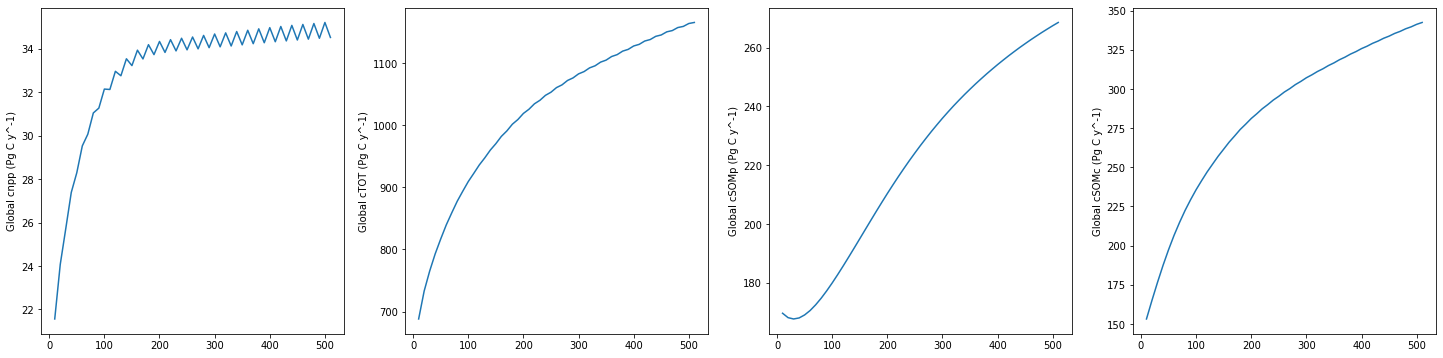

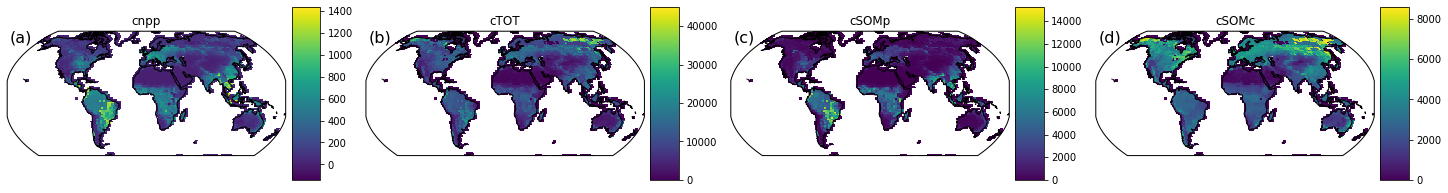

In [5]:
Cvars =['cnpp','cTOT','cSOMp','cSOMc']
globalSum(ds,Cvars, plot=True)

# Now call the map_function
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

for index, ax in np.ndenumerate(axes):
    i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = ds[Cvars[index[0]]].isel(time=-1)
    map_function(da, panel=panel[i], ax=ax, title=Cvars[index[0]], cb=1)

### Look at changes in soil pools in last 100 years

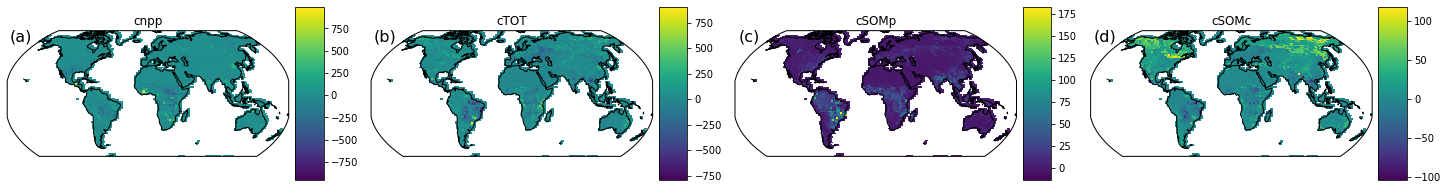

In [24]:
Cvars =['cnpp','cTOT','cSOMp','cSOMc']
d_ds = ds.isel(time=-1) - ds.isel(time=-2)
f_ds = d_ds/ds.isel(time=-1)*100
# Now call the map_function
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

for index, ax in np.ndenumerate(axes):
    i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = d_ds[Cvars[index[0]]]
    map_function(da, panel=panel[i], ax=ax, title=Cvars[index[0]], cb=1)
    

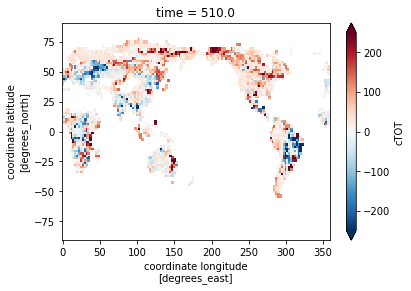

In [7]:
d_ds['cTOT'].where(ds.cgpp.isel(time=-1)>50).plot(robust=True);

In [8]:
#ds['cnpp'].where(ds.cgpp.isel(time=-1)>50).isel(time=-1).plot(robust=True);

### Total soil C:N

mean(cnTOT)= 12.628268 %
min, max(cnTOT) = 7.919028, 23.398668 %


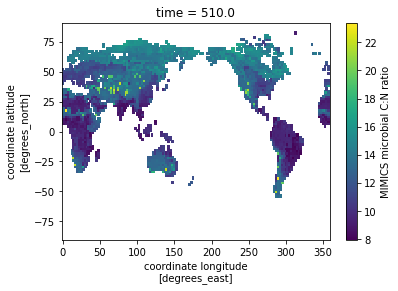

In [9]:
print('mean(cnTOT)= '+str(ds['cnTOT'].mean().values)+' %')
print('min, max(cnTOT) = '+str(ds['cnTOT'].min().values)+
      ', '+str(ds['cnTOT'].max().values)+' %')

ds['cnTOT'].isel(time=-1).plot(robust=False);

### Microbial C:N

min(cnMIC) =  5.999626 %
max(cnMIC) =  9.999999 %


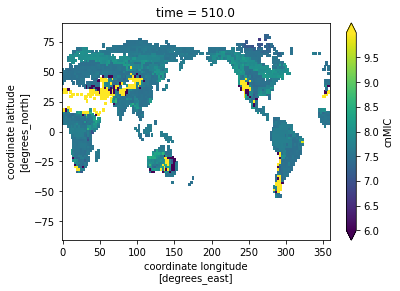

In [17]:
minGPP = 10
ds['cnMIC'].where(ds['cgpp']>minGPP).isel(time=-1).plot(robust=True);
print('min(cnMIC) =  '+str(ds['cnMIC'].where(ds['cgpp']>minGPP).isel(time=-1).min().values)+' %')
print('max(cnMIC) =  '+str(ds['cnMIC'].where(ds['cgpp']>minGPP).isel(time=-1).max().values)+' %')

### Microbial r:K ratio

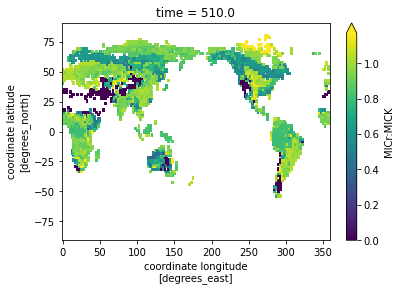

In [18]:
ds['MICrK'].where(ds['cgpp']>minGPP).isel(time=-1).plot(robust=True);

### Ratio of microbial biomass to total C

mean(relMIC)= 0.8871506 %
min, max(relMIC) = 0.055826943, 5.296471 %


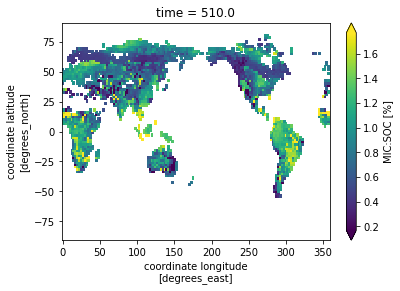

In [19]:
ds['relMIC'].where(ds['cgpp']>minGPP).isel(time=-1).plot(robust=True);
print('mean(relMIC)= '+
      str(ds['relMIC'].where(ds['cgpp']>minGPP).isel(time=-1).mean().values)+' %')
print('min, max(relMIC) = '+
      str(ds['relMIC'].where(ds['cgpp']>minGPP).isel(time=-1).min().values)+', '+
      str(ds['relMIC'].where(ds['cgpp']>minGPP).isel(time=-1).max().values)+' %')


---------------------
## Look at MIMCS_Conly w/ GSWP3 & CRU + CASAcn

In [20]:
cruConlyIN = '/project/tss/wwieder/CASACLM/GRID/OUTPUT_GRID_CRU_NCEP/MIMICS_SPIN_b/'
CcasCRU = cruConlyIN+'casaclm_pool_flux_9000_9980.nc'
CmimCRU = cruConlyIN+'mimics_pool_flux_9000_9980.nc'
print('CmimCRU = ' +CmimCRU)

simMIMc = 'MIMICS_mod4_dens1.0_KO6_Conly'
caseMIMc = 'GRID_CN/'+simMIMc+'/OUTPUT_C/SPIN/'
Ccas = path+caseMIMc+'casaclm_pool_flux_*80.nc' 
Cmim = path+caseMIMc+'mimics_pool_flux_*80.nc' 
print('Cmim = '+Cmim)

simCASc  = 'CASACNP_GSWP3_Conly' 
caseCASc = 'GRID_CN/'+simCASc+'/OUTPUT_C/SPIN/'
full_pathCASc = path+caseCASc+'casaclm_pool_flux_*80.nc' # casa files for vegetation results
print('Ccas = '+full_pathCASc)

simCAScn  = 'CASACNP_mod3_borealNfix_GSWP3' 
caseCAScn = 'GRID_CN/'+simCAScn+'/OUTPUT_CN/SPIN/'
full_pathCAScn = path+caseCAScn+'casaclm_pool_flux_*80.nc' # casa files for vegetation results
print('CNcas = '+full_pathCAScn)

CmimCRU = /project/tss/wwieder/CASACLM/GRID/OUTPUT_GRID_CRU_NCEP/MIMICS_SPIN_b/mimics_pool_flux_9000_9980.nc
Cmim = /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod4_dens1.0_KO6_Conly/OUTPUT_C/SPIN/mimics_pool_flux_*80.nc
Ccas = /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/CASACNP_GSWP3_Conly/OUTPUT_C/SPIN/casaclm_pool_flux_*80.nc
CNcas = /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/CASACNP_mod3_borealNfix_GSWP3/OUTPUT_CN/SPIN/casaclm_pool_flux_*80.nc


### Open each dataset

In [21]:
# MIMICS, C-only, CRU-NCEP
dsCmimCRU   = xr.open_mfdataset(CmimCRU, decode_times=True,combine='by_coords') 
dsCvegCRU   = xr.open_mfdataset(CcasCRU, decode_times=True,combine='by_coords')
dsCmimCRU['cnpp'] = dsCvegCRU['cnpp'] # copy plant productivity to mimics files
dsCmimCRU['cgpp'] = dsCvegCRU['cgpp']

# MIMICS, C-only, GSWP3
dsCveg   = xr.open_mfdataset(Ccas,  decode_times=True, combine='by_coords') 
dsCmim   = xr.open_mfdataset(Cmim,  decode_times=True, combine='by_coords') 
dsCmim['cnpp'] = dsCveg['cnpp'] # copy plant productivity to mimics files
dsCmim['cgpp'] = dsCveg['cgpp']

# CASA C-only & CN, GSPW3
dsCcas    = xr.open_mfdataset(full_pathCASc,  decode_times=True, combine='by_coords') #CASA, C-only, GSWP3
dsCNcas   = xr.open_mfdataset(full_pathCAScn, decode_times=True, combine='by_coords') #
print (' -- data read in -- ')

 -- data read in -- 


#### Sum pools & print mean

In [22]:
dsCmimCRU = utils.sum_pools(dsCmimCRU, mod='mim', CN='False')
dsCmim  = utils.sum_pools(dsCmim, mod='mim', CN='False')
dsCcas  = utils.sum_pools(dsCcas,  mod='cas', CN='False')
dsCNcas = utils.sum_pools(dsCNcas, mod='cas', CN='True' )

In [25]:
Cvars =['cgpp','cnpp','cTOT']
# MIMICS_Conly results, GSWP3
print('')
print('MIMICS_C only GSWP3')
globalSum(dsCmim,Cvars, plot=False)

# MIMICS_CN results
print('')
print(sim+'CN results')
globalSum(ds,Cvars, plot=False)

# CASA_C results
print('')
print('CASA-C, GSWP3 results')
globalSum(dsCcas,Cvars, plot=False)

# CASA_CN results
print('')
print('CASA-CN, GSWP3 results')
globalSum(dsCNcas,Cvars, plot=False)

# MIMICS_C, CRUNCEP
print('')
print('MIMICS_C only CRUNCEP')
globalSum(dsCmimCRU,Cvars, plot=False)


MIMICS_C only GSWP3
global cgpp 105.3 Pg C
global cnpp 42.0 Pg C
global cTOT 1474.6 Pg C

MIMICS_mod4_dens1.0_KO6_GSWP3CN results
global cgpp 103.6 Pg C
global cnpp 34.5 Pg C
global cTOT 1165.2 Pg C

CASA-C, GSWP3 results
global cgpp 105.3 Pg C
global cnpp 42.0 Pg C
global cTOT 939.4 Pg C

CASA-CN, GSWP3 results
global cgpp 105.3 Pg C
global cnpp 39.0 Pg C
global cTOT 839.8 Pg C
MIMICS_C only CRUNCEP
global cgpp 118.6 Pg C
global cnpp 48.9 Pg C
global cTOT 1470.3 Pg C


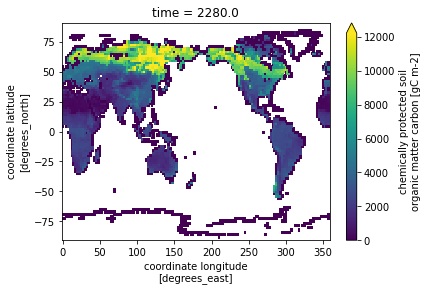

In [26]:
dsCmim.isel(time=-1).cSOMc.plot(robust=True);

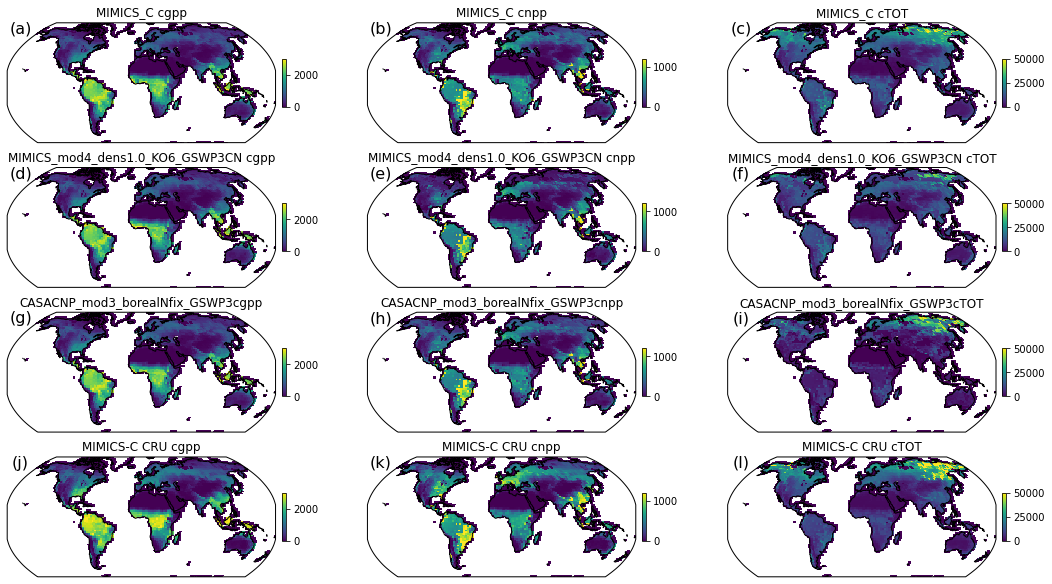

In [27]:
# Call the map_function
sims = ['MIMICS_C ',(sim+'CN '),simCAScn, 'MIMICS-C CRU ']
Cvars =['cgpp','cnpp','cTOT']
vmax = [3000  ,1200  ,5e4]  #max values for each variable

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    i = index[0]
    j = index[1]
    k = k+1
    if i == 0: da = dsCmim[Cvars[j]].isel(time=-1)
    if i == 1: da = ds[Cvars[j]].isel(time=-1)
    if i == 2: da = dsCNcas[Cvars[j]].isel(time=-1)
    if i == 3: da = dsCmimCRU[Cvars[j]].isel(time=-1)

    map_function(da, panel=panel[k], ax=ax, vmax=vmax[j], vmin=0, title=sims[i]+Cvars[j], cb=1)

## Difference in NPP (CN-C)
- most notably in boreal forests.
- somewhat int tropcs

In [28]:
# MIMICS-C GSPW3 - MIMICS-C CRUNCEP
inVars  = ['cnpp','cTOT','cSOMp', 'cSOMc']
newVars = ['d_cnpp','d_cTOT','d_cSOMp', 'd_cSOMc']

for i in range(len(inVars)):
    # MIMICS-C GSWP3 - MIMICS-C CRUNCEP
    dsCmim[newVars[i]] = (dsCmim[inVars[i]].isel(time=-1) - dsCmimCRU[inVars[i]].isel(time=-1))
    dsCmim[newVars[i]].attrs['long_name'] = 'MIMICS C GSWP3 '+inVars[i]+' difference from CRUNCEP'

    # MIMICS-CN -  MIMICS-Conly GSWP3
    ds[newVars[i]] = (ds[inVars[i]].isel(time=-1) - dsCmim[inVars[i]].isel(time=-1))
    ds[newVars[i]].attrs['long_name'] = sim+'CN '+inVars[i]+' difference from Conly'

    if (i<2):
        # CASA-CN - MIMICS-CN GSWP3
        dsCNcas[newVars[i]] = (dsCNcas[inVars[i]].isel(time=-1) - ds[inVars[i]].isel(time=-1))
        dsCNcas[newVars[i]].attrs['long_name'] = 'CASAcn '+inVars[i]+' difference from '+sim+'CN'

### Call the map_function for: 
- MIMICScn - MIMICS_Conly
- CASAcn - MIMICS_Conly
- MIMICS_Conly GSWP3 - CRUNCEP

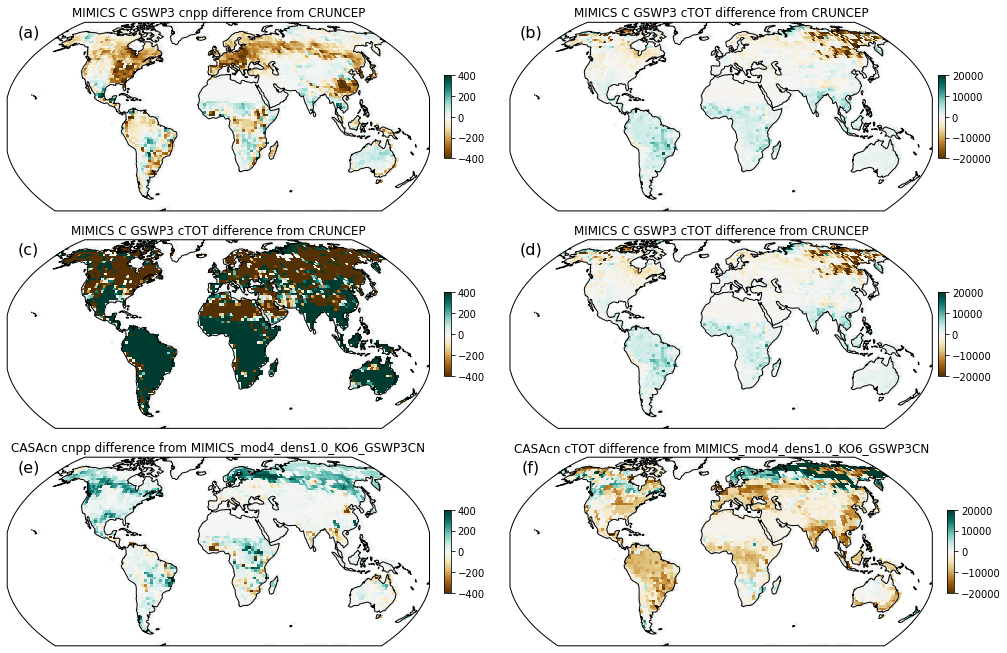

In [29]:
Cvars = ['d_cnpp','d_cTOT']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,9), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    i = index[0]
    j = index[1]
    k = k+1
    if i == 0 : da = dsCmim[Cvars[j]]
    if i == 2 : da = ds[Cvars[j]]
    if i == 2 : da = dsCNcas[Cvars[j]]

    if j==0:
        #map_function(da, panel=panel[k], ax=ax, title=da.attrs['long_name'], cb=1,cmap='BrBG', vmax=75, vmin=-75) # for % change
        map_function(da, panel=panel[k], ax=ax, title=da.attrs['long_name'], cb=1,cmap='BrBG', vmax=400, vmin=-400) # for absolute change
    else:
        map_function(da, panel=panel[k], ax=ax, title=da.attrs['long_name'], cb=1,cmap='BrBG', vmax=2e4, vmin=-2e4)
    

## Look at zonal mean plots for lat. bands

In [30]:
var  =  ['cnpp', 'cgpp','cTOT']
varLong  =  ['npp', 'gpp','total soil C']

# sum up fluxes
ann_fluxCNmim = ds * ds.landarea *1e6
ann_fluxCNcas = dsCNcas * dsCNcas.landarea *1e6
ann_fluxCmim  = dsCmim * dsCmim.landarea *1e6
ann_fluxCmimCRU = dsCmimCRU * dsCmimCRU.landarea *1e6
for i in range(len(var)):
    ann_fluxCNmim.get(var[i]).attrs['units'] = 'gC y-1'
    ann_fluxCNcas.get(var[i]).attrs['units'] = 'gC y-1'
    ann_fluxCmim.get(var[i]).attrs['units'] = 'gC y-1'    
    ann_fluxCmimCRU.get(var[i]).attrs['units'] = 'gC y-1'

In [31]:
zon_sumCNmim = ann_fluxCNmim.sum(dim='lon') *1e-15
zon_sumCNcas = ann_fluxCNcas.sum(dim='lon') *1e-15
zon_sumCmim = ann_fluxCmim.sum(dim='lon') *1e-15
zon_sumCmimCRU = ann_fluxCmimCRU.sum(dim='lon') *1e-15
# unweighted zonal means
zon_meanCNmim = ds.mean(dim='lon') 
zon_meanCNcas = dsCNcas.mean(dim='lon') 
zon_meanCmim = dsCmim.mean(dim='lon') 
zon_meanCmimCRU = dsCmimCRU.mean(dim='lon') 

## Read in HWSD SOC pools for comparison

<xarray.DataArray 'NCSCD_SOC' (lat: 268, lon: 1440)>
dask.array<open_dataset-75145b2633ab0eac66247c3471f7965cNCSCD_SOC, shape=(268, 1440), dtype=float64, chunksize=(268, 1440)>
Coordinates:
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float64 89.88 89.63 89.38 89.13 ... 23.88 23.63 23.38 23.13
Attributes:
    long_name:       NCSCD_Circumarctic_100cmSOCC_025deg.tif
    esri_pe_string:  GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1...
    units:           Degree

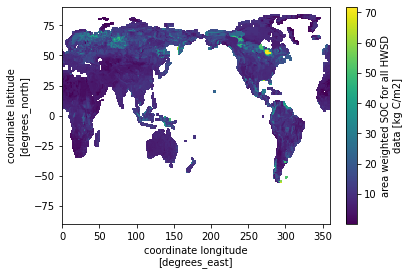

In [32]:
obsIn = "/project/tss/wwieder/soilCN/global_run/input_data/"
HWSD = obsIn+'Soil_obs.nc'
NCSCD = obsIn+'NCSCD_Circumarctic_100cmSOCC_025deg.nc'
dsOBS = xr.open_mfdataset(HWSD, decode_times=True,combine='by_coords')
dsNCSCD = xr.open_mfdataset(NCSCD, decode_times=True,combine='by_coords')
dsOBS['HWSD_SOCall'] = dsOBS.HWSD_SOC.sum(dim='nlevsoi').where(dsOBS.HWSD_SOC.isel(nlevsoi=0)>0)
dsOBS['HWSD_SOCall'].attrs = dsOBS.HWSD_SOC.attrs
#dsOBS.ISRIC_SOC.plot();
dsOBS.HWSD_SOCall.plot();
zon_meanOBS = dsOBS.mean(dim='lon') * 1000 #gC/m2
dsNCSCD.NCSCD_SOC

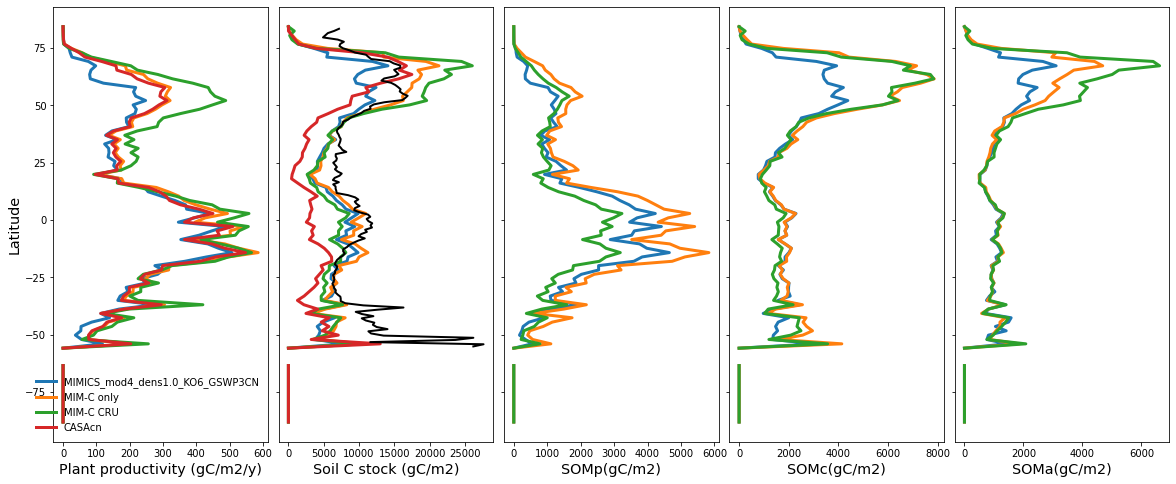

In [33]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=[20,8])
# Remove space between axes
fig.subplots_adjust(hspace=0, wspace=0.05)

labels = [sim+'CN','MIM-C only','MIM-C CRU','CASAcn']
ax1.plot(zon_meanCNmim.get('cnpp').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax1.plot(zon_meanCmim.get('cnpp').isel(time=-1),  zon_meanCmim.lat,  lw=3)
ax1.plot(zon_meanCmimCRU.get('cnpp').isel(time=-1),  zon_meanCmimCRU.lat,  lw=3)
ax1.plot(zon_meanCNcas.get('cnpp').isel(time=-1), zon_meanCNcas.lat, lw=3)
ax1.set_xlabel('Plant productivity (gC/m2/y)', fontsize='x-large')
ax1.set_ylabel('Latitude', fontsize='x-large');
ax1.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

ax2.plot(zon_meanCNmim.get('cTOT').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax2.plot(zon_meanCmim.get('cTOT').isel(time=-1),  zon_meanCmim.lat,  lw=3)
ax2.plot(zon_meanCmimCRU.get('cTOT').isel(time=-1),  zon_meanCmimCRU.lat,  lw=3)
ax2.plot(zon_meanCNcas.get('cTOT').isel(time=-1), zon_meanCNcas.lat, lw=3)
ax2.plot(zon_meanOBS.get('HWSD_SOCall'), zon_meanOBS.lat,lw=2, color='k')
#ax2.plot(zon_meanOBS.get('ISRIC_SOC'), zon_meanOBS.lat,lw=2, color='k')
ax2.set_xlabel('Soil C stock (gC/m2)', fontsize='x-large')

ax3.plot(zon_meanCNmim.get('cSOMp').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax3.plot(zon_meanCmim.get('cSOMp').isel(time=-1),  zon_meanCmim.lat,  lw=3)
ax3.plot(zon_meanCmimCRU.get('cSOMp').isel(time=-1),  zon_meanCmimCRU.lat,  lw=3)
ax3.set_xlabel('SOMp(gC/m2)', fontsize='x-large');

ax4.plot(zon_meanCNmim.get('cSOMc').isel(time=-1), zon_sumCNmim.lat, lw=3)
ax4.plot(zon_meanCmim.get('cSOMc').isel(time=-1),  zon_meanCmim.lat,  lw=3)
ax4.plot(zon_meanCmimCRU.get('cSOMc').isel(time=-1),  zon_meanCmimCRU.lat,  lw=3)
#ax4.plot(zon_sumCNcas.get('csoilslow').isel(time=-1), zon_meanCNcas.lat, lw=3
ax4.set_xlabel('SOMc(gC/m2)', fontsize='x-large');

ax5.plot(zon_meanCNmim.get('cSOMa').isel(time=-1), zon_meanCNmim.lat, lw=3)
ax5.plot(zon_meanCmim.get('cSOMa').isel(time=-1),  zon_meanCmim.lat,  lw=3)
ax5.plot(zon_meanCmimCRU.get('cSOMa').isel(time=-1),  zon_meanCmimCRU.lat,  lw=3)
#ax5.plot(zon_sumCNcas.get('csoilmic').isel(time=-1), zon_meanCNcas.lat, lw=3
ax5.set_xlabel('SOMa(gC/m2)', fontsize='x-large');

#### NPP
- N limitation reduces NPP in all  models, expecially w/ CASA
- CRUNCEP has higher mid & high latitude NPP than GSWP3 forcing

### Total SOM
- lower with CN models, especially in  boreal forest & arctic,  where NPP is lower
- most of MIMICS decreases are in SOMc

### SOM pools
- large drop in SOMc with MIMICScn
- also increases in microbial biomass (fraction of total SOM)
- modify microbial kinnetics of SOMc to increase  SOMc & decrease MIC

In [34]:
# Check that inputs look normal

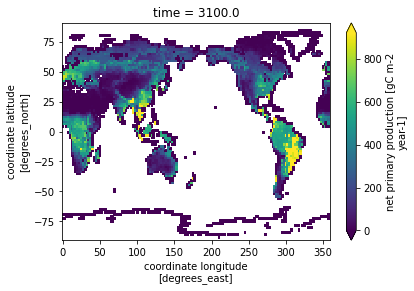

In [24]:
ds.cnpp.isel(time=-1).plot(robust=True);

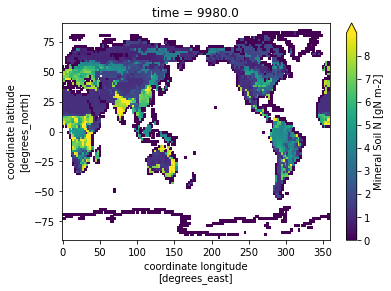

In [25]:
dsCNcas.nMineral.isel(time=-1).plot(robust=True);

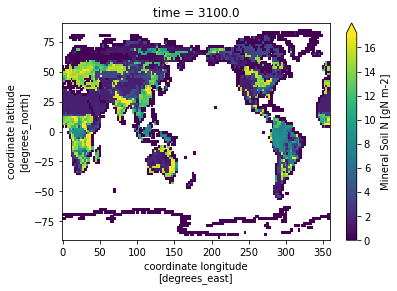

In [26]:
ds.nMineral.isel(time=-1).plot(robust=True);

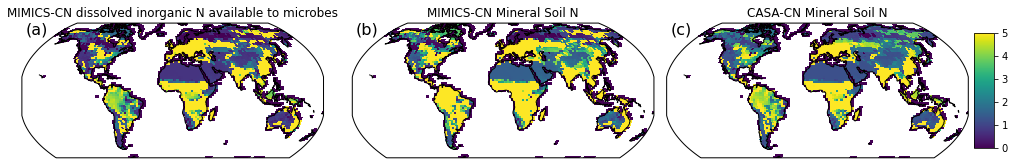

In [27]:
Nvars = ['DIN','nMineral','nMineral']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
k=-1
for index, ax in np.ndenumerate(axes):
    i = index[0]
    if i <=1 : 
        da = ds[Nvars[i]].isel(time=-1)
        map_function(da, panel=panel[i], ax=ax, title='MIMICS-CN '+da.attrs['long_name'], cb=0, vmax=5, vmin=0) 

    if i == 2 : 
        da = dsCNcas[Nvars[i]].isel(time=-1)
        map_function(da, panel=panel[i], ax=ax, title='CASA-CN '+da.attrs['long_name'], cb=1, vmax=5, vmin=0) 

